Predictive Modeling for Case Delays
Objective: Building a predictive model to estimate the likelihood of case delays based on the case type, district, and other factors (like number of senior citizen cases, cases filed by women).
Approach: Apply classification algorithms (like logistic regression, decision trees) to predict case delays.

Objective: Creating a geospatial visualization showing the distribution of pending cases across various states and districts.
Approach: Will use tools like Folium or GeoPandas to map the court case data geographically and identify any regional patterns in case types and backlogs.

In [1]:
import pandas as pd
data = pd.read_csv('Updated_Court_Case_Data_with_Entropy_Weights.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Updated_Court_Case_Data_with_Entropy_Weights.csv'

In [2]:
# Check for unique district names in the dataset
unique_districts = data['srcDistrictName'].unique()

# Display the unique district names
unique_districts


NameError: name 'data' is not defined

In [ ]:
import json

# Load the uploaded GeoJSON file
geojson_path = 'Indian_Districts_Simplified.geojson'
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Extract district names and basic properties from the GeoJSON file
districts_data = [
    {
        "district_name": feature["properties"].get("district", "Unknown District"),
        "geometry": feature["geometry"]
    }
    for feature in geojson_data["features"]
]

# Display the first few extracted district names and geometries (without complex polygon structures)
districts_data[:2]


In [ ]:
# Create a dictionary from the GeoJSON data for easier lookup of district names and geometries
geojson_districts = {entry["district_name"].lower(): entry["geometry"] for entry in districts_data}

# Normalize the district names in the dataset for comparison
data['normalized_district_name'] = data['srcDistrictName'].str.lower()

# Perform a lookup to add geometry data to the dataset based on district names
data['geometry'] = data['normalized_district_name'].map(geojson_districts)

# Check how many districts were successfully matched
matched_districts_count = data['geometry'].notnull().sum()
total_districts_count = len(data)

# Display the count of matched districts and the total
matched_districts_count, total_districts_count


In [ ]:
# Investigate the unmatched districts
unmatched_districts = data[data['geometry'].isnull()]['srcDistrictName'].unique()

# Display the unmatched district names
unmatched_districts[:20]  # Displaying first 20 unmatched district names as an example


In [ ]:
# Install fuzzywuzzy if not already installed (commented out for this environment)
!pip install fuzzywuzzy[speedup] --quiet

from fuzzywuzzy import process

# List of districts from the GeoJSON data
geojson_district_names = [entry['district_name'] for entry in districts_data]

# Function to apply fuzzy matching for each unmatched district
def fuzzy_match_districts(unmatched_districts, geojson_district_names, threshold=80):
    matched_districts = {}
    for district in unmatched_districts:
        match, score = process.extractOne(district, geojson_district_names)
        if score >= threshold:  # If the match score is above the threshold, consider it a valid match
            matched_districts[district] = match
    return matched_districts

# Apply fuzzy matching
fuzzy_matched_districts = fuzzy_match_districts(unmatched_districts, geojson_district_names)

# Display a few fuzzy matched districts
fuzzy_matched_districts


In [ ]:
# Adjust the fuzzy match function for stricter district-only matching
def fuzzy_match_districts_refined(unmatched_districts, geojson_district_names, threshold=90):
    matched_districts = {}
    for district in unmatched_districts:
        match, score = process.extractOne(district, geojson_district_names)
        if score >= threshold:  # Refined threshold of 90 to reduce mismatches
            matched_districts[district] = match
    return matched_districts

# Apply refined fuzzy matching with the district names only and higher threshold
refined_fuzzy_matched_districts = fuzzy_match_districts_refined(unmatched_districts, geojson_district_names)

# Display the refined fuzzy matched districts
refined_fuzzy_matched_districts


In [ ]:
# Manually fixing the ambiguous matches
manual_corrections = {
    'East': 'East Delhi',
    'North': 'North Delhi',
    'North West': 'North West Delhi',
    'South West': 'South West Delhi',
    'West': 'West Delhi',
    'South': 'South Delhi',
    'South East': 'South East Delhi'
}

# Apply manual corrections
for district, correct_district in manual_corrections.items():
    if district in refined_fuzzy_matched_districts:
        refined_fuzzy_matched_districts[district] = correct_district

# Update the dataset with the manually corrected matches
data['geometry'] = data['normalized_district_name'].map(geojson_districts)
for district, correct_district in manual_corrections.items():
    # Find the row with this district and update its geometry
    data.loc[data['srcDistrictName'] == district, 'geometry'] = geojson_districts[correct_district.lower()]

# Display a sample of the updated dataset to verify
data[['srcStateName', 'srcDistrictName', 'geometry']].head()


Court Efficiency Index
Goal: Quantify and compare the efficiency of different courts in resolving cases over a given period.
Analysis: Create a composite index for each district based on the ratio of cases filed vs. disposed, delays, and the percentage of old pending cases. Map this index to show which districts have the most/least efficient court systems.
Value: Can be used as a performance metric for identifying underperforming courts, providing actionable insights for policy makers.

Steps for the Analysis:
Data Preparation:

Use the columns related to cases filed, disposed, and pending over various periods from the dataset.
Create new metrics to calculate efficiency, such as:
Case Disposal Rate: cases disposed/cases filed
​
 
Delay Ratio: cases delayed in disposal/total cases

​
 
Old Pending Cases Percentage: pending cases over 5 years/total pending cases
​ 
Composite Index Calculation:

Normalize the values for each metric (e.g., case disposal rate, delay ratio, percentage of old pending cases) to bring them to a comparable scale.
Assign weights to each of the metrics based on importance (for example, disposal rate might be given more weight than delay ratio).
Calculate a Court Efficiency Index (CEI) by combining these normalized and weighted values.
Geospatial Visualization:

Plot the Court Efficiency Index on a map to visualize court performance across regions.
Highlight areas with high and low court efficiency scores.
Insights:

Identify regions with low efficiency and investigate contributing factors (e.g., high delays, poor disposal rates).
Offer recommendations for resource allocation or process improvements.

The key metrics for the Court Efficiency Index have been calculated successfully:

Case Disposal Rate: The rate at which cases are disposed compared to those filed.
Delay Ratio: The proportion of cases that are delayed in disposal relative to the total cases.
Old Pending Cases Percentage: The percentage of pending cases that are over 5 years old.
Next Steps:
Normalize the metrics so that they can be compared on a common scale.
Assign weights to these metrics (we can assume equal weights for now, unless a different weighting strategy is preferred).
Calculate the final composite Court Efficiency Index (CEI).
Visualize the CEI across districts.

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Calculate total cases (sum of pending cases across years)
total_cases = data['Pending cases']

# Step 2: Calculate Delay Ratio: cases delayed in disposal / total cases
data['Delay_Ratio'] = data['Cases delayed in disposal'] / (total_cases + 1)  # Avoid division by zero

# Step 3: Calculate Old Pending Cases Percentage: pending cases over 5 years / total pending cases
pending_cases_over_5_years = (data['Pending cases for a period of 5 to 10 Years'] +
                              data['Pending cases for a period of 10 to 20 Years'] +
                              data['Pending cases for a period of 20 to 30 Years'] +
                              data['Pending cases over 30 Years'])
data['Old_Pending_Percentage'] = pending_cases_over_5_years / (total_cases + 1)  # Avoid division by zero

# Step 4: Calculate Pending Case Growth (simulated as pending cases minus disposed cases)
data['Pending_Case_Growth'] = (total_cases - data['Cases disposed in last month']) / (total_cases + 1)

# Step 5: Calculate Case Disposal Rate based only on total pending cases and disposed cases
data['Case_Disposal_Rate'] = data['Cases disposed in last month'] / (total_cases + 1)  # Avoid division by zero

# Step 6: Calculate Pending to Disposed Ratio
data['Pending_to_Disposed_Ratio'] = total_cases / (data['Cases disposed in last month'] + 1)  # Avoid division by zero

# Normalizing the metrics using Min-Max normalization
data['Normalized_Case_Disposal_Rate'] = (data['Case_Disposal_Rate'] - data['Case_Disposal_Rate'].min()) / (data['Case_Disposal_Rate'].max() - data['Case_Disposal_Rate'].min())
data['Normalized_Delay_Ratio'] = (data['Delay_Ratio'] - data['Delay_Ratio'].min()) / (data['Delay_Ratio'].max() - data['Delay_Ratio'].min())
data['Normalized_Old_Pending_Percentage'] = (data['Old_Pending_Percentage'] - data['Old_Pending_Percentage'].min()) / (data['Old_Pending_Percentage'].max() - data['Old_Pending_Percentage'].min())
data['Normalized_Pending_Case_Growth'] = (data['Pending_Case_Growth'] - data['Pending_Case_Growth'].min()) / (data['Pending_Case_Growth'].max() - data['Pending_Case_Growth'].min())
data['Normalized_Pending_to_Disposed_Ratio'] = (data['Pending_to_Disposed_Ratio'] - data['Pending_to_Disposed_Ratio'].min()) / (data['Pending_to_Disposed_Ratio'].max() - data['Pending_to_Disposed_Ratio'].min())

# Step 7: Prepare data for PCA by scaling
normalized_metrics = data[['Normalized_Case_Disposal_Rate', 'Normalized_Delay_Ratio',
                           'Normalized_Old_Pending_Percentage', 'Normalized_Pending_Case_Growth',
                           'Normalized_Pending_to_Disposed_Ratio']]
scaler = StandardScaler()
normalized_metrics_scaled = scaler.fit_transform(normalized_metrics)

# Step 8: Apply PCA and extract absolute weights from the first principal component
pca = PCA()
pca.fit(normalized_metrics_scaled)
pca_weights_absolute = np.abs(pca.components_[0]) / np.sum(np.abs(pca.components_[0]))  # Ensure all weights are positive

# Step 9: Recalculate Court Efficiency Index with absolute PCA-derived weights
data['Court_Efficiency_Index_PCA_Absolute'] = (
    data['Normalized_Case_Disposal_Rate'] * pca_weights_absolute[0] +
    (1 - data['Normalized_Delay_Ratio']) * pca_weights_absolute[1] +
    (1 - data['Normalized_Old_Pending_Percentage']) * pca_weights_absolute[2] +
    (1 - data['Normalized_Pending_Case_Growth']) * pca_weights_absolute[3] +
    (1 - data['Normalized_Pending_to_Disposed_Ratio']) * pca_weights_absolute[4]
)

# Step 10: Create a separate dataset with each district name and its Court Efficiency Index based on absolute PCA weights for total cases only
total_cases_data_pca_absolute = data[data['District and Taluk Court Case type'] == 'Total'][
    ['srcStateName', 'srcDistrictName', 'Court_Efficiency_Index_PCA_Absolute']
]

# Optional: Save the updated datasets
# data.to_csv("Updated_Court_Case_Data_with_Absolute_PCA_Weights.csv", index=False)
# total_cases_data_pca_absolute.to_csv("District_Total_Cases_Court_Efficiency_PCA_Absolute.csv", index=False)

# Display the PCA-based weights and confirm calculation
print("Absolute PCA-Based Weights:")
print(pca_weights_absolute)
print("\nTop rows of Court Efficiency Index (PCA with Absolute Weights):")
print(total_cases_data_pca_absolute.head())


NameError: name 'data' is not defined

The Court Efficiency Index (CEI) has been successfully calculated for each district. The index is based on normalized values for case disposal rate, delay ratio (inverted), and old pending cases percentage (inverted), weighted equally.
Next Step:
Visualization: We can now create a geospatial map to display the Court Efficiency Index across different districts. This will help identify regions with high or low efficiency in court case management.

In [3]:

# Load the re-uploaded dataset for district-level court efficiency (total cases only)
total_cases_data = pd.read_csv('District_Total_Cases_Court_Efficiency_PCA_Absolute.csv')

# Group by state and calculate the mean efficiency for each state based on district-level "total cases" efficiency
statewise_efficiency = total_cases_data.groupby('srcStateName', as_index=False)['Court_Efficiency_Index'].mean()

# Rename columns for clarity
statewise_efficiency.rename(columns={'srcStateName': 'StateName', 'Court_Efficiency_Index': 'Statewise_Court_Efficiency'}, inplace=True)

# # Save the statewise efficiency dataset
statewise_efficiency_path = "Statewise_Total_Cases_Court_Efficiency.csv"
statewise_efficiency.to_csv(statewise_efficiency_path, index=False)

# # Display the path for downloading the statewise efficiency dataset
# statewise_efficiency_path
print(statewise_efficiency.head())



             StateName  Statewise_Court_Efficiency
0  Andaman and Nicobar                    0.301052
1       Andhra Pradesh                    0.531194
2    Arunachal Pradesh                    0.566698
3                Assam                    0.538319
4                Bihar                    0.299828


## How Visualizing Districts into Clusters on an India Map Helps in My Project

### 1. Identify Regional Patterns
- **Why it matters**: By clustering districts based on metrics such as **court efficiency** and **case backlog**, you can easily spot regional patterns. For instance, certain clusters may indicate regions where courts are more efficient, while other clusters might highlight areas with severe backlogs.
- **How it helps**: Visualizing clusters enables you to prioritize areas for further investigation or intervention. For example, you could focus on specific regions with poor performance and assess what causes the inefficiencies there.

### 2. Support Decision-Making
- **Why it matters**: Decision-makers (e.g., judiciary authorities, policymakers, etc.) need data-backed insights to allocate resources like judges, staff, and infrastructure. Visualizing court performance by clusters helps them quickly identify where resources are most needed.
- **How it helps**: The clustered map allows stakeholders to determine which regions need more resources for court improvements, such as reducing backlogs or enhancing court efficiency. It can guide decisions like expanding judicial infrastructure in regions with larger backlogs.

### 3. Spotting Outliers and Exceptional Performance
- **Why it matters**: Clustering districts based on court data can highlight districts that stand out, whether as outliers with unusually high efficiency or districts that are struggling significantly more than others.
- **How it helps**: Outliers can be valuable case studies for understanding both best practices (in the case of efficient districts) and problem areas (in the case of underperforming districts). By identifying clusters with unusual behavior, you can study what makes these districts different and replicate successful strategies elsewhere.

### 4. Comparative Analysis Across States and Districts
- **Why it matters**: A visual comparison of clusters helps you contrast regions not only by state but also by specific district performance.
- **How it helps**: You can compare how different states or even neighboring districts fare in terms of efficiency and backlog management. This comparison helps identify whether systemic issues (state-wide inefficiency) or localized problems (district-specific issues) are at play.

### 5. Communication of Insights
- **Why it matters**: Maps and visualizations are easier for stakeholders to understand than raw data tables or charts. Maps help convey complex data in a simple and intuitive manner.
- **How it helps**: Visualizing the clusters on a map allows you to present your findings in an engaging, easy-to-interpret way, making it more likely that non-technical stakeholders (such as government officials, lawyers, and policymakers) will take action based on your insights.

### 6. Spatial Analysis for Further Research
- **Why it matters**: Spatial clustering allows you to link geographic factors (e.g., population density, infrastructure, socio-economic status) with court performance. This enables deeper analysis into why certain areas perform better or worse.
- **How it helps**: You can overlay additional layers of data (such as population, poverty levels, or infrastructure) to see how these factors correlate with the court's efficiency or backlog. This can provide insights into the root causes of inefficiencies and offer avenues for improving court performance in those regions.

### 7. Basis for Predictive Modeling
- **Why it matters**: Visualized clusters can form the foundation for predictive models that forecast future backlogs or efficiency improvements based on current data.
- **How it helps**: After identifying patterns in clusters, you can build predictive models to forecast where backlogs might increase in the future or predict the impact of interventions like adding more judicial staff. This helps in planning long-term solutions for court management.

### 8. Aligning Judicial Reforms and Policy Interventions
- **Why it matters**: The clusters help you align judicial reforms more accurately. For example, districts in the worst-performing clusters could be targeted for judicial reform programs, while districts in better-performing clusters could serve as examples of best practices.
- **How it helps**: Policy recommendations based on cluster analysis become more targeted and effective. You could propose tailored reforms like fast-tracking specific types of cases (e.g., criminal vs. civil) in districts with the most delays---

### How to Apply This in Your Project:

- **Analysis of Backlog Reduction**: Focus on districts with the highest backlogs and compare them to those with low backlogs in the same state to understand whether regional policies are effective or not.
  
- **Efficient Resource Allocation**: The visualization can help you suggest where more courts, staff, or digital tools (e.g., case management software) should be deployed.

- **Benchmarking Best Practices**: Identify high-efficiency districts and benchmark their practices (e.g., case distribution, workload handling, digital interventions). These best practices can then be applied to lower-performing districts.

---

### Conclusion:
Visualizing the court efficiency and backlog clusters on the map is a powerful tool that can help you:
- **Diagnose the problem areas** (i.e., districts with the largest case backlogs or inefficiencies),
- **Communicate effectively with stakeholders** using intuitive visualizations, and
- **Guide decision-making and interventions** in judicial processes for better resource allocation and reforms.

This approach integrates spatial and performance data, making your project more insightful and actionable.


Correlation Analysis
Objective: Find correlations between court performance metrics and other demographic or regional factors.
How:
Perform a correlation analysis between the court efficiency and various other features like case backlogs, population, senior citizen cases, and cases filed by women.
Identify strong correlations (positive or negative) that may explain the reasons behind backlogs or efficiencies.
Next Step: Run a correlation matrix between variables to detect patterns.

C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vikrant Mishra\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You c

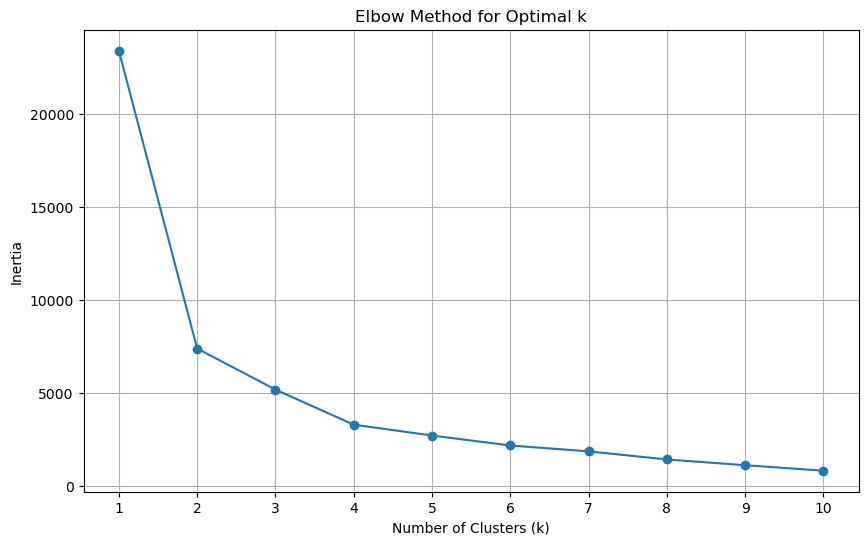

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Updated_Court_Case_Data_with_Absolute_PCA_Weights.csv')

# Selecting relevant numerical features for clustering
features = [
    'Pending cases for a period of 0 to 1 Years',
    'Pending cases for a period of 1 to 3 Years',
    'Pending cases for a period of 3 to 5 Years',
    'Pending cases for a period of 5 to 10 Years',
    'Pending cases for a period of 10 to 20 Years',
    'Pending cases for a period of 20 to 30 Years',
    'Pending cases over 30 Years',
    'Pending cases',
    'Case_Disposal_Rate',
    'Pending_to_Disposed_Ratio',
    'Court_Efficiency_Index'
]

# Handling missing values and converting to numeric
data[features] = data[features].apply(pd.to_numeric, errors='coerce')
data = data.dropna(subset=features)  # Drop rows with missing values in selected features

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Finding the optimal number of clusters using the elbow method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()


In [ ]:
# Fitting K-Means with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42)
data['Cluster_3'] = kmeans_3.fit_predict(scaled_features)

# Fitting K-Means with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
data['Cluster_4'] = kmeans_4.fit_predict(scaled_features)

# Display the number of districts in each cluster for both clustering results
cluster_counts_3 = data['Cluster_3'].value_counts().sort_index()
cluster_counts_4 = data['Cluster_4'].value_counts().sort_index()

# Creating a summary DataFrame for cluster counts
cluster_summary = pd.DataFrame({
    'Cluster_3': cluster_counts_3,
    'Cluster_4': cluster_counts_4
})

cluster_summary


In [6]:
# Required imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Selecting relevant features and the target variable
features = [
    'Pending_to_Disposed_Ratio',
    'Normalized_Pending_Case_Growth',
    'Pending_Case_Growth',
    'Normalized_Pending_to_Disposed_Ratio',
    'Pending cases for a period of 0 to 1 Years',
    'Normalized_Old_Pending_Percentage',
    'Normalized_Delay_Ratio'
]


target = 'Court_Efficiency_Index'

# Splitting the dataset into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
svr_model = SVR()
knn_model = KNeighborsRegressor()

# Training and predicting with Linear Regression
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

# Training and predicting with Random Forest Regressor
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Training and predicting with Gradient Boosting Regressor
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Training and predicting with Support Vector Regressor
svr_model.fit(X_train, y_train)
svr_predictions = svr_model.predict(X_test)

# Training and predicting with K-Nearest Neighbors Regressor
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluating the models using R-squared and Mean Squared Error
results = {
    "Linear Regression": {
        "R-squared": r2_score(y_test, linear_predictions),
        "MSE": mean_squared_error(y_test, linear_predictions)
    },
    "Random Forest": {
        "R-squared": r2_score(y_test, rf_predictions),
        "MSE": mean_squared_error(y_test, rf_predictions)
    },
    "Gradient Boosting": {
        "R-squared": r2_score(y_test, gb_predictions),
        "MSE": mean_squared_error(y_test, gb_predictions)
    },
    "Support Vector Regressor": {
        "R-squared": r2_score(y_test, svr_predictions),
        "MSE": mean_squared_error(y_test, svr_predictions)
    },
    "K-Nearest Neighbors": {
        "R-squared": r2_score(y_test, knn_predictions),
        "MSE": mean_squared_error(y_test, knn_predictions)
    }
}

# Output the evaluation results
results

{'Linear Regression': {'R-squared': 0.7537973780744913,
  'MSE': 0.00036692947941225495},
 'Random Forest': {'R-squared': 0.9767733429723844,
  'MSE': 3.4615980548771634e-05},
 'Gradient Boosting': {'R-squared': 0.9809830483460392,
  'MSE': 2.8342022175974555e-05},
 'Support Vector Regressor': {'R-squared': 0.13248251143835588,
  'MSE': 0.0012929096285386496},
 'K-Nearest Neighbors': {'R-squared': 0.4000916487271634,
  'MSE': 0.0008940768270705383}}

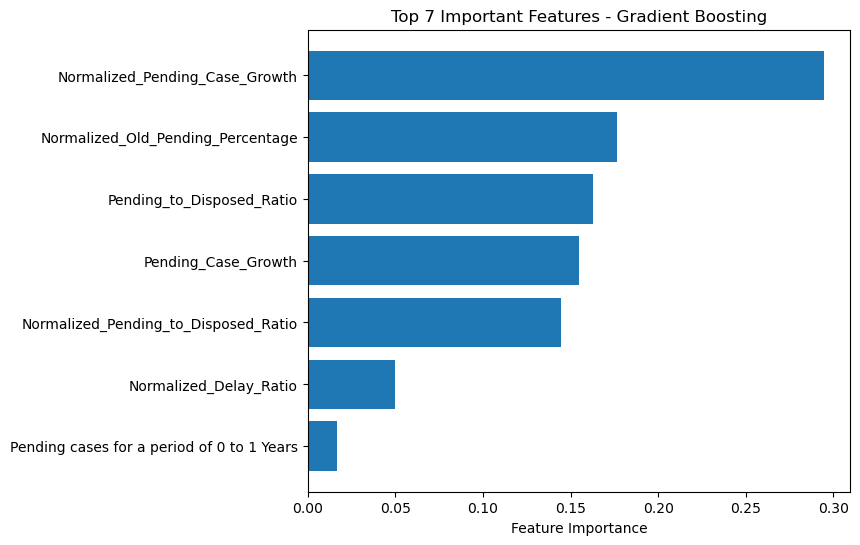

In [8]:
# Let's visualize the feature importance from the Gradient Boosting model.

import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the trained Gradient Boosting model
feature_importances = gb_model.feature_importances_

# Get the feature names from the one-hot encoded data
feature_names = X.columns

# Sort feature importances in descending order and plot
sorted_idx = np.argsort(feature_importances)[::-1]
top_n = 7  # Displaying top 8 important features

plt.figure(figsize=(7, 6))
plt.barh(range(top_n), feature_importances[sorted_idx][:top_n], align='center')
plt.yticks(range(top_n), feature_names[sorted_idx][:top_n])
plt.xlabel("Feature Importance")
plt.title("Top 7 Important Features - Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()


while the model indicates that Normalized Case Disposal Rate is highly important, it's best to verify whether this dependence is justified and if the model generalizes well before proceeding solely based on this feature.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Load the dataset
data = pd.read_csv("Updated_Court_Case_Data_with_Absolute_PCA_Weights.csv")

# Preprocess the data
X = pd.get_dummies(data.drop(columns=["Court_Efficiency_Index"]), drop_first=True)
y = data["Court_Efficiency_Index"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

# Load your dataset
data = pd.read_csv("Updated_Court_Case_Data_with_Absolute_PCA_Weights.csv")

# Specify features and target
features = [
    'Pending_to_Disposed_Ratio',
    'Normalized_Pending_Case_Growth',
    'Pending_Case_Growth',
    'Normalized_Pending_to_Disposed_Ratio',
    'Pending cases for a period of 0 to 1 Years',
    'Normalized_Old_Pending_Percentage',
    'Normalized_Delay_Ratio'
]
target = 'Court_Efficiency_Index'

# Prepare data
X = data[features]
y = data[target]
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Define hyperparameters for RandomizedSearch
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), 
                                   param_distributions=param_grid, n_iter=10, 
                                   cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

# Output the results
best_params = random_search.best_params_
best_gb_model = random_search.best_estimator_
predictions = best_gb_model.predict(X_test)
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("Best Parameters:", best_params)
print("R-squared:", r2)
print("MSE:", mse)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
R-squared: 0.9770976272155616
MSE: 3.413268168054676e-05


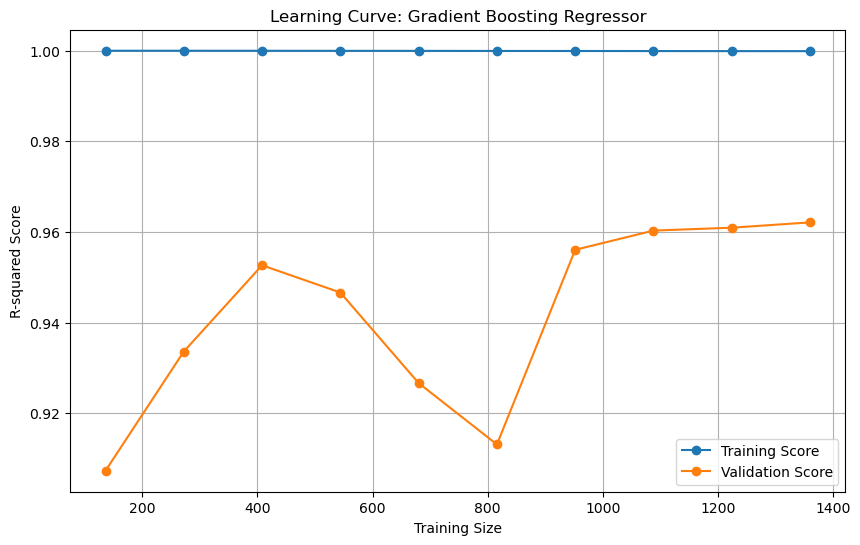

In [12]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2"
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Score", marker='o')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("R-squared Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curve for the tuned Gradient Boosting model
plot_learning_curve(best_gb_model, X_train, y_train, title="Learning Curve: Gradient Boosting Regressor")


In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Reduce max_depth, increase min_samples_split, and min_samples_leaf to reduce overfitting
param_grid = {
    'n_estimators': [50, 100],  # Fewer trees
    'learning_rate': [0.01, 0.05],  # Keep learning rate low
    'max_depth': [3, 4],  # Reduce tree depth to limit complexity
    'min_samples_split': [10, 15],  # More samples needed to split a node
    'min_samples_leaf': [4, 6]  # More samples per leaf to prevent overfitting
}

gb_model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
best_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_

# Predictions and evaluation
predictions = best_gb_model.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("Best Parameters: ", best_params)
print("R-squared: ", r2)
print("MSE: ", mse)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters:  {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}
R-squared:  0.9814970250512385
MSE:  2.757601406690644e-05


In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

param_grid = {
    'n_estimators': [50, 75],  # Further reduce the number of trees
    'learning_rate': [0.01, 0.05],  # Lower learning rate
    'max_depth': [2, 3],  # Limit depth even further
    'min_samples_split': [15, 20],  # Larger split to require more samples
    'min_samples_leaf': [6, 8],  # Larger leaf size
    'subsample': [0.7, 0.8]  # Randomly subsample the data to reduce variance
}

# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
best_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_

# Predictions and evaluation
predictions = best_gb_model.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("Best Parameters: ", best_params)
print("R-squared: ", r2)
print("MSE: ", mse)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 75, 'subsample': 0.8}
R-squared:  0.9680963184913108
MSE:  4.7547833389278896e-05


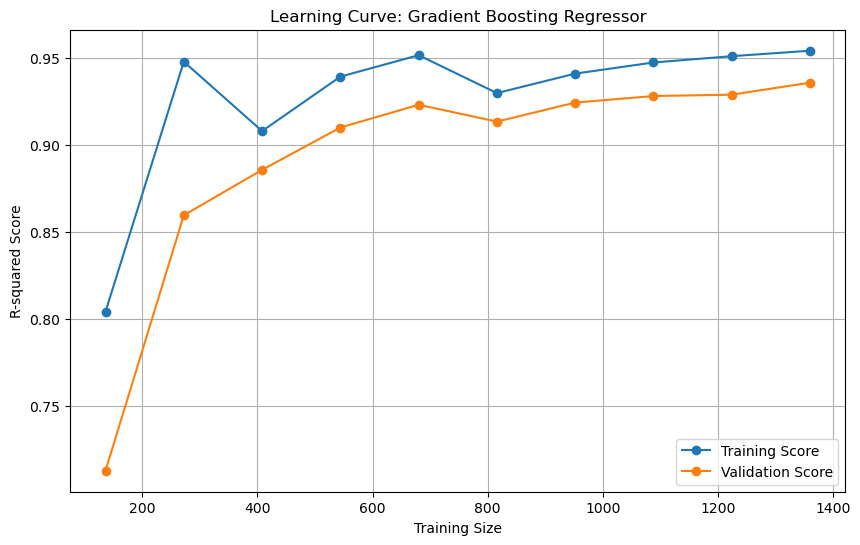

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Specify the exact features you want to use for training
features = [
    'Pending_to_Disposed_Ratio',
    'Normalized_Pending_Case_Growth',
    'Pending_Case_Growth',
    'Normalized_Pending_to_Disposed_Ratio',
    'Pending cases for a period of 0 to 1 Years',
    'Normalized_Old_Pending_Percentage',
    'Normalized_Delay_Ratio'
]
target = 'Court_Efficiency_Index'

# Select only the specified numeric feature columns and the target
X_new = data[features]
y_new = data[target]

# Impute missing values in the features (if any)
imputer = SimpleImputer(strategy='mean')
X_new = imputer.fit_transform(X_new)

# Split the data: 80% training, 20% holdout test set (Unseen data)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Define the best model based on the previous tuning
best_gb_model_final = GradientBoostingRegressor(
    n_estimators=75, learning_rate=0.05, max_depth=3,
    min_samples_split=15, min_samples_leaf=6, subsample=0.8, random_state=42
)

# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2"
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Score", marker='o')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("R-squared Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot the learning curve for the final model
plot_learning_curve(best_gb_model_final, X_train_final, y_train_final, title="Learning Curve: Gradient Boosting Regressor")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Specify the exact features you want to use for training
features = [
    'Pending_to_Disposed_Ratio',
    'Normalized_Pending_Case_Growth',
    'Pending_Case_Growth',
    'Normalized_Pending_to_Disposed_Ratio',
    'Pending cases for a period of 0 to 1 Years',
    'Normalized_Old_Pending_Percentage',
    'Normalized_Delay_Ratio'
]
target = 'Court_Efficiency_Index'

# Select only the specified numeric feature columns and the target
X_new = data[features]
y_new = data[target]

# Impute missing values in the features (if any)
imputer = SimpleImputer(strategy='mean')
X_new = imputer.fit_transform(X_new)

# Split the data: 80% training, 20% holdout test set (Unseen data)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Define the best model with added regularization based on observations
best_gb_model_final = GradientBoostingRegressor(
    n_estimators=75, learning_rate=0.05, max_depth=3,
    min_samples_split=20, min_samples_leaf=10, subsample=0.7, random_state=42
)

# Function to plot learning curves with 10-fold cross-validation
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring="r2"
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
    plt.plot(train_sizes, test_scores_mean, label="Validation Score", marker='o')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("R-squared Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot the learning curve for the final model with the improvements
plot_learning_curve(best_gb_model_final, X_train_final, y_train_final, title="Learning Curve: Improved Gradient Boosting Regressor")

# Fit the model on the training set and evaluate on the test set
best_gb_model_final.fit(X_train_final, y_train_final)
test_r2_score = best_gb_model_final.score(X_test_final, y_test_final)
print(f"Test R-squared Score: {test_r2_score:.4f}")


In [ ]:
# import joblib

# # Save the trained model to a file
# joblib.dump(best_gb_model_final, 'gradient_boosting_model.joblib')


In [17]:
model = joblib.load('gradient_boosting_model.joblib')

NameError: name 'joblib' is not defined

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_final)

# Calculate performance metrics
mse = mean_squared_error(y_test_final, y_pred)
mae = mean_absolute_error(y_test_final, y_pred)
r2 = r2_score(y_test_final, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred, alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

# Plot residuals
residuals = y_test_final - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


NameError: name 'model' is not defined

In [18]:
from sklearn.model_selection import cross_val_score

# Perform 10-Fold Cross-Validation
scores = cross_val_score(best_gb_model, X_new, y_new, cv=10, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Mean R²: {scores.mean():.4f}")
print(f"Standard Deviation of R²: {scores.std():.4f}")


Cross-validated R² scores: [0.92260111 0.97568956 0.96155552 0.88833502 0.95219149 0.81841264
 0.95976118 0.96033918 0.90608615 0.96223812]
Mean R²: 0.9307
Standard Deviation of R²: 0.0461


In [19]:
from sklearn.utils import resample
import numpy as np

bootstrapped_scores = []
n_bootstraps = 10  # Number of bootstrap samples

for i in range(n_bootstraps):
    X_bootstrap, y_bootstrap = resample(X_new, y_new, random_state=i)
    score = cross_val_score(best_gb_model, X_bootstrap, y_bootstrap, cv=5, scoring='r2').mean()
    bootstrapped_scores.append(score)

print(f"Bootstrapped R² scores: {bootstrapped_scores}")
print(f"Mean Bootstrapped R²: {np.mean(bootstrapped_scores):.4f}")
print(f"Standard Deviation of Bootstrapped R²: {np.std(bootstrapped_scores):.4f}")


Bootstrapped R² scores: [0.9171136788524186, 0.9791525583446348, 0.9799586651085257, 0.9230429294575833, 0.9782349410261435, 0.9541780894516245, 0.9100632709921342, 0.9311558888173985, 0.9413169535349066, 0.9752270504687062]
Mean Bootstrapped R²: 0.9489
Standard Deviation of Bootstrapped R²: 0.0265


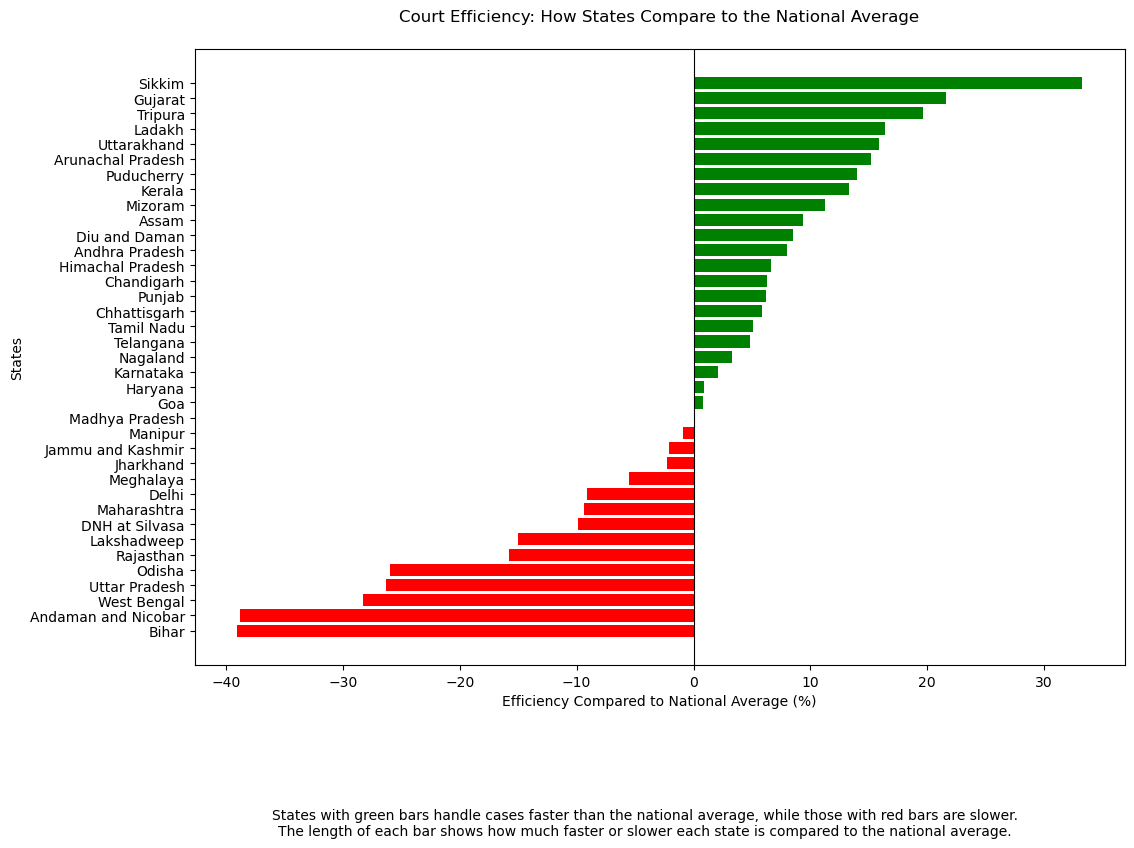

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data_new = pd.read_csv('Statewise_Total_Cases_Court_Efficiency.csv')

# Calculate the national average for Court Efficiency Index
national_avg_efficiency = data_new['Statewise_Court_Efficiency'].mean()

# Calculate the relative performance for each state compared to the national average
data_new['Rel_Court_Efficiency_National'] = (
    (data_new['Statewise_Court_Efficiency'] - national_avg_efficiency) / national_avg_efficiency
) * 100

# Plot the bar chart with clear labels and accessible title
plt.figure(figsize=(12, 8))
data_new.sort_values('Rel_Court_Efficiency_National', inplace=True)
plt.barh(data_new['StateName'], data_new['Rel_Court_Efficiency_National'], 
         color=['green' if x > 0 else 'red' for x in data_new['Rel_Court_Efficiency_National']])
plt.axvline(0, color='black', linewidth=0.8)

# Accessible title and labels
plt.title("Court Efficiency: How States Compare to the National Average", pad=20)
plt.xlabel("Efficiency Compared to National Average (%)")
plt.ylabel("States")

# Explanation caption
plt.figtext(0.5, -0.1, 
            "States with green bars handle cases faster than the national average, while those with red bars are slower.\n"
            "The length of each bar shows how much faster or slower each state is compared to the national average.",
            wrap=True, horizontalalignment='center', fontsize=10)



# Show the plot
plt.show()


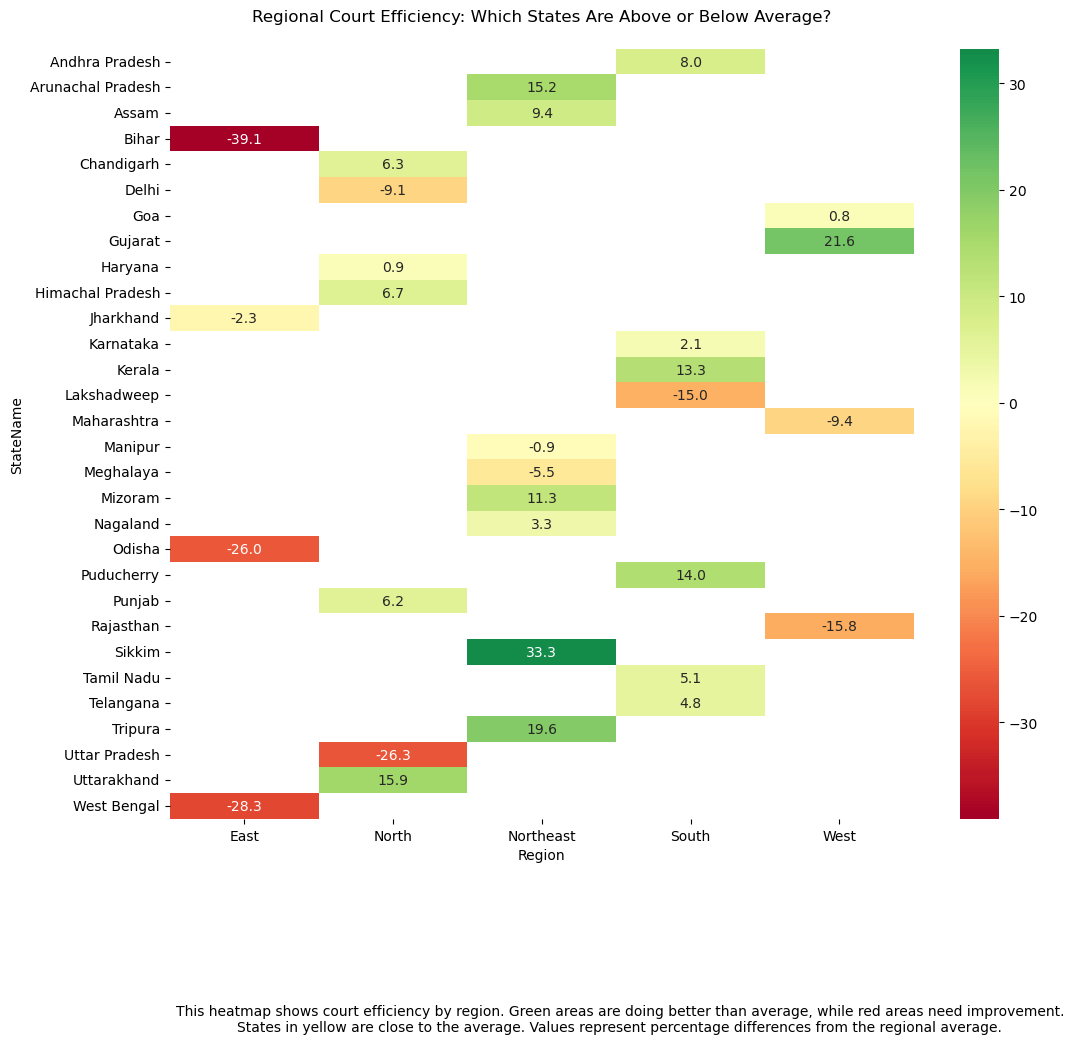

In [21]:
# Defining the regions for Indian states
state_regions = {
    'Jammu & Kashmir': 'North', 'Himachal Pradesh': 'North', 'Punjab': 'North', 'Haryana': 'North', 
    'Delhi': 'North', 'Uttarakhand': 'North', 'Uttar Pradesh': 'North', 'Chandigarh': 'North',
    'Andhra Pradesh': 'South', 'Telangana': 'South', 'Karnataka': 'South', 'Tamil Nadu': 'South', 
    'Kerala': 'South', 'Puducherry': 'South', 'Lakshadweep': 'South',
    'Bihar': 'East', 'Jharkhand': 'East', 'Odisha': 'East', 'West Bengal': 'East',
    'Rajasthan': 'West', 'Gujarat': 'West', 'Maharashtra': 'West', 'Goa': 'West',
    'Dadra and Nagar Haveli': 'West', 'Daman and Diu': 'West',
    'Assam': 'Northeast', 'Arunachal Pradesh': 'Northeast', 'Manipur': 'Northeast', 
    'Meghalaya': 'Northeast', 'Mizoram': 'Northeast', 'Nagaland': 'Northeast', 
    'Sikkim': 'Northeast', 'Tripura': 'Northeast'
}

# Adding a 'Region' column to the statewise data based on the state
data_new['Region'] = data_new['StateName'].map(state_regions)

# Dropping rows where region assignment might have failed (if any state is unmatched)
data_new = data_new.dropna(subset=['Region'])

# Aggregating by both state and region to calculate the relative efficiency for the heatmap
regional_data = data_new.groupby(['StateName', 'Region']).agg({'Statewise_Court_Efficiency': 'mean'}).reset_index()
regional_data['Rel_Court_Efficiency_National'] = (
    (regional_data['Statewise_Court_Efficiency'] - national_avg_efficiency) / national_avg_efficiency
) * 100

# Pivoting the data for heatmap creation
pivot_data = regional_data.pivot(index="StateName", columns="Region", values="Rel_Court_Efficiency_National")

# Plotting the heatmap with regional efficiency comparisons
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_data, annot=True, cmap="RdYlGn", center=0, fmt=".1f")

# Adding accessible title and labels
plt.title("Regional Court Efficiency: Which States Are Above or Below Average?", pad=20)
plt.figtext(0.5, -0.1, 
            "This heatmap shows court efficiency by region. Green areas are doing better than average, while red areas need improvement.\n"
            "States in yellow are close to the average. Values represent percentage differences from the regional average.",
            wrap=True, horizontalalignment='center', fontsize=10)


plt.show()


In [ ]:
# import pandas as pd

# # Load the Excel file
# file_path = '2011-IndiaStateDist-0000.xlsx'  # Replace with your file path
# xls = pd.ExcelFile(file_path)

# # Load the 'Data' sheet from the Excel file
# df = pd.read_excel(xls, sheet_name='Data')

# # Filter necessary columns and keep only district-level entries
# df_population = df[['State', 'District', 'Name', 'TRU', 'TOT_P', 'Level']]
# df_population = df_population[df_population['Level'] == 'DISTRICT']

# # Pivot the data to have separate columns for rural, urban, and total populations
# df_pivot = df_population.pivot_table(index=['State', 'District', 'Name'], columns='TRU', values='TOT_P').reset_index()

# # Map state codes to state names by creating a dictionary from unique state entries
# state_mapping = df[df['Level'] == 'STATE'][['State', 'Name']].drop_duplicates()
# state_code_to_name = dict(zip(state_mapping['State'], state_mapping['Name']))
# df_pivot['State_Name'] = df_pivot['State'].map(state_code_to_name)

# # Rename columns for clarity
# df_pivot.columns = ['State_Code', 'District_Code', 'District_Name', 'Rural_Population', 'Total_Population', 'Urban_Population', 'State_Name']

# # Reorder columns for better readability
# df_pivot = df_pivot[['State_Code', 'State_Name', 'District_Code', 'District_Name', 'Rural_Population', 'Total_Population', 'Urban_Population']]

# # Save the modified data to a new Excel file
# output_path = 'Indian_District_Population.xlsx'  # Specify your desired output path
# df_pivot.to_excel(output_path, index=False)

# print(f"Data saved to {output_path}")


In [22]:
import pandas as pd

# Load the datasets
court_data = pd.read_csv('Updated_Court_Case_Data_with_Absolute_PCA_Weights.csv')
population_data = pd.read_excel('Indian_District_Population.xlsx')

# Step 1: Filter for total cases only and create an explicit copy
court_data_total = court_data[court_data['District and Taluk Court Case type'] == 'Total'].copy()

# Step 2: Standardize names to uppercase for merging using .loc to avoid warnings
court_data_total.loc[:, 'State_Name'] = court_data_total['srcStateName'].str.upper()
court_data_total.loc[:, 'District_Name'] = court_data_total['srcDistrictName'].str.upper()
population_data['State_Name'] = population_data['State_Name'].str.upper()
population_data['District_Name'] = population_data['District_Name'].str.upper()

# Step 3: Merge on state and district names
merged_data = pd.merge(
    court_data_total, 
    population_data[['State_Name', 'District_Name', 'Total_Population']], 
    on=['State_Name', 'District_Name'], 
    how='inner'
)

# Step 4: Calculate Cases per Capita using total cases (Pending cases) for each district
merged_data['Cases_per_Capita'] = merged_data['Pending cases'] / merged_data['Total_Population']

# Step 5: Calculate Judicial Efficiency Index per Capita for total cases
merged_data['Judicial_Efficiency_Index_per_Capita'] = merged_data['Court_Efficiency_Index_PCA'] * merged_data['Cases_per_Capita']

# Select relevant columns for output
judicial_efficiency_per_capita = merged_data[['State_Name', 'District_Name', 'Court_Efficiency_Index_PCA', 
                                              'Total_Population', 'Pending cases', 'Cases_per_Capita', 
                                              'Judicial_Efficiency_Index_per_Capita']]

# Save the result to a CSV file
# judicial_efficiency_per_capita.to_csv('Judicial_Efficiency_Index_Per_Capita_Total_Cases.csv', index=False)

print("Judicial Efficiency Index per Capita for total cases calculated and saved as 'Judicial_Efficiency_Index_Per_Capita_Total_Cases.csv'.")


ImportError: Pandas requires version '3.1.0' or newer of 'openpyxl' (version '3.0.10' currently installed).

In [ ]:
import pandas as pd

# Load the datasets
court_data = pd.read_csv('Updated_Court_Case_Data_with_Absolute_PCA_Weights.csv')
population_data = pd.read_excel('Indian_District_Population.xlsx')

# Step 1: Filter for total cases only
court_data_total = court_data[court_data['District and Taluk Court Case type'] == 'Total'].copy()

# Step 2: Standardize names to uppercase for merging using .loc to avoid warnings
court_data_total.loc[:, 'State_Name'] = court_data_total['srcStateName'].str.upper()
court_data_total.loc[:, 'District_Name'] = court_data_total['srcDistrictName'].str.upper()
population_data['State_Name'] = population_data['State_Name'].str.upper()
population_data['District_Name'] = population_data['District_Name'].str.upper()

# Step 3: Merge on state and district names
merged_data = pd.merge(
    court_data_total, 
    population_data[['State_Name', 'District_Name', 'Total_Population']], 
    on=['State_Name', 'District_Name'], 
    how='inner'
)

# Step 4: Aggregate to state level
statewise_data = merged_data.groupby('State_Name').agg(
    Total_Court_Efficiency_Index=('Court_Efficiency_Index_PCA', 'mean'),
    Total_Cases=('Pending cases', 'sum'),  # Total cases from 'Pending cases' column
    Total_Population=('Total_Population', 'sum')
).reset_index()

# Step 5: Calculate Cases per Capita for each state
statewise_data['Cases_per_Capita'] = statewise_data['Total_Cases'] / statewise_data['Total_Population']

# Step 6: Calculate Judicial Efficiency Index per Capita for each state
statewise_data['Judicial_Efficiency_Index_per_Capita'] = statewise_data['Total_Court_Efficiency_Index'] * statewise_data['Cases_per_Capita']

# Select relevant columns for output
statewise_efficiency_per_capita = statewise_data[['State_Name', 'Total_Court_Efficiency_Index', 
                                                  'Total_Population', 'Cases_per_Capita', 
                                                  'Judicial_Efficiency_Index_per_Capita']]

# Save the result to a CSV file
# statewise_efficiency_per_capita.to_csv('Statewise_Judicial_Efficiency_Index_Per_Capita.csv', index=False)

print("Statewise Judicial Efficiency Index per Capita calculated and saved as 'Statewise_Judicial_Efficiency_Index_Per_Capita.csv'.")


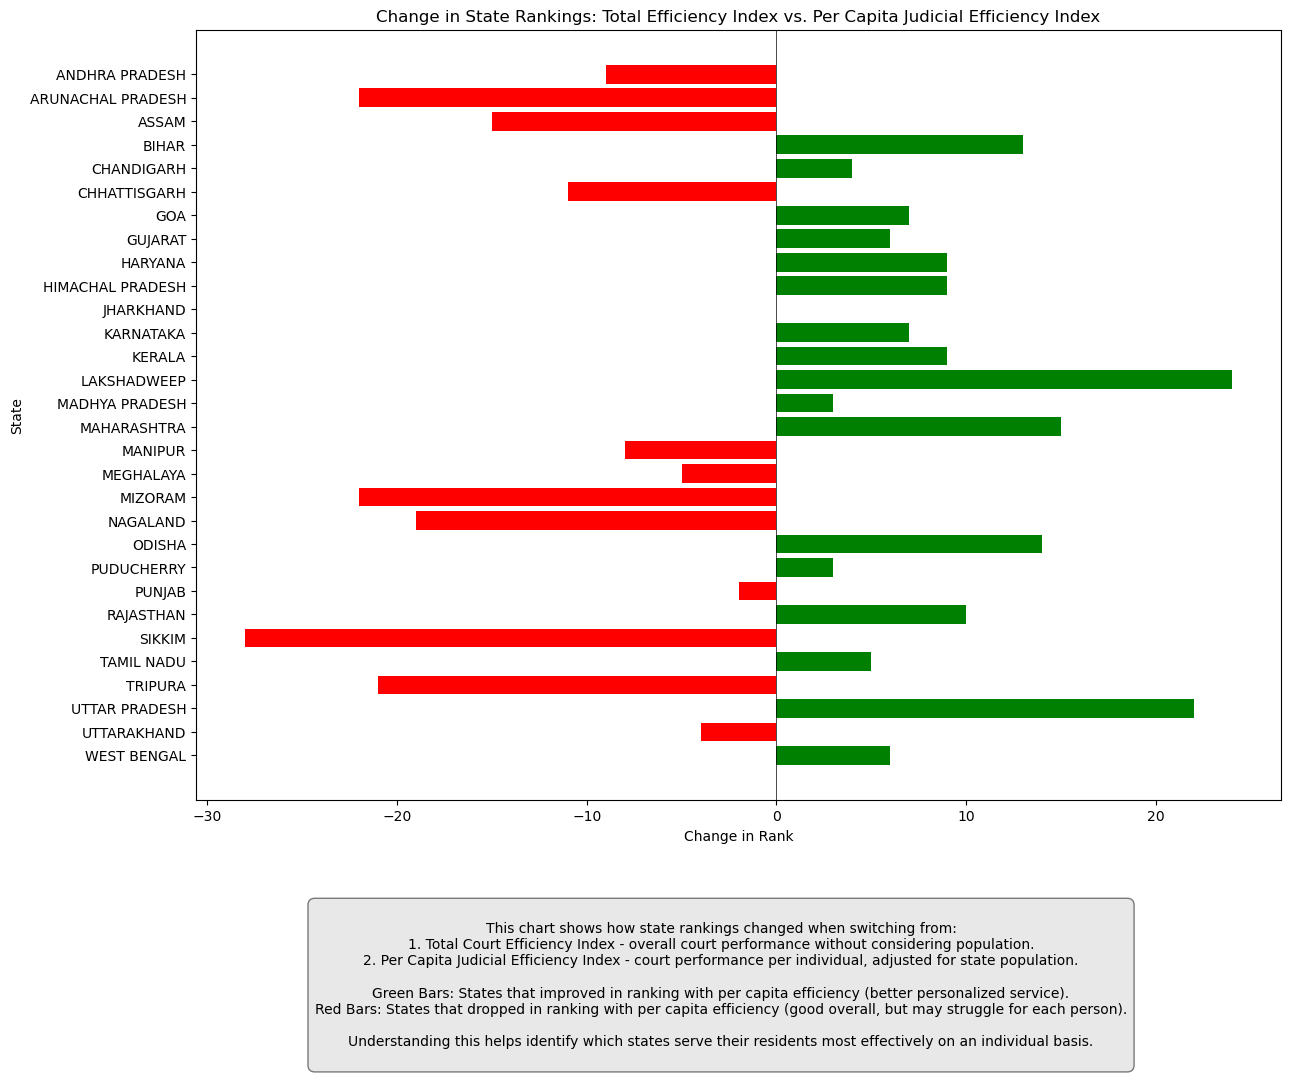

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframes
efficiency_index_df = pd.read_csv('Statewise_Judicial_Efficiency_Index_Per_Capita.csv')
total_cases_df = pd.read_csv('Statewise_Total_Cases_Court_Efficiency.csv')

# Compute ranks for `Total_Court_Efficiency_Index` and `Judicial_Efficiency_Index_per_Capita`
efficiency_index_df['Efficiency_Rank'] = efficiency_index_df['Total_Court_Efficiency_Index'].rank(method='min', ascending=False)
efficiency_index_df['Per_Capita_Efficiency_Rank'] = efficiency_index_df['Judicial_Efficiency_Index_per_Capita'].rank(method='min', ascending=False)
efficiency_index_df['Rank_Change'] = efficiency_index_df['Efficiency_Rank'] - efficiency_index_df['Per_Capita_Efficiency_Rank']

# Plotting with color-coded bars
plt.figure(figsize=(14, 10))
colors = np.where(efficiency_index_df['Rank_Change'] > 0, 'green', 'red')
bars = plt.barh(efficiency_index_df['State_Name'], efficiency_index_df['Rank_Change'], color=colors)
plt.xlabel('Change in Rank')
plt.ylabel('State')
plt.title('Change in State Rankings: Total Efficiency Index vs. Per Capita Judicial Efficiency Index')

# Add explanatory text
explanation_text = """
This chart shows how state rankings changed when switching from:
1. Total Court Efficiency Index - overall court performance without considering population.
2. Per Capita Judicial Efficiency Index - court performance per individual, adjusted for state population.

Green Bars: States that improved in ranking with per capita efficiency (better personalized service).
Red Bars: States that dropped in ranking with per capita efficiency (good overall, but may struggle for each person).

Understanding this helps identify which states serve their residents most effectively on an individual basis.
"""
plt.figtext(0.5, -0.15, explanation_text, wrap=True, horizontalalignment='center', fontsize=10, bbox=dict(facecolor='lightgrey', alpha=0.5, boxstyle="round,pad=0.5"))

# Draw a vertical line at zero for reference
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()

# Save the chart as a file
plt.savefig('state_rankings_comparison_chart.png', bbox_inches='tight', dpi=300)


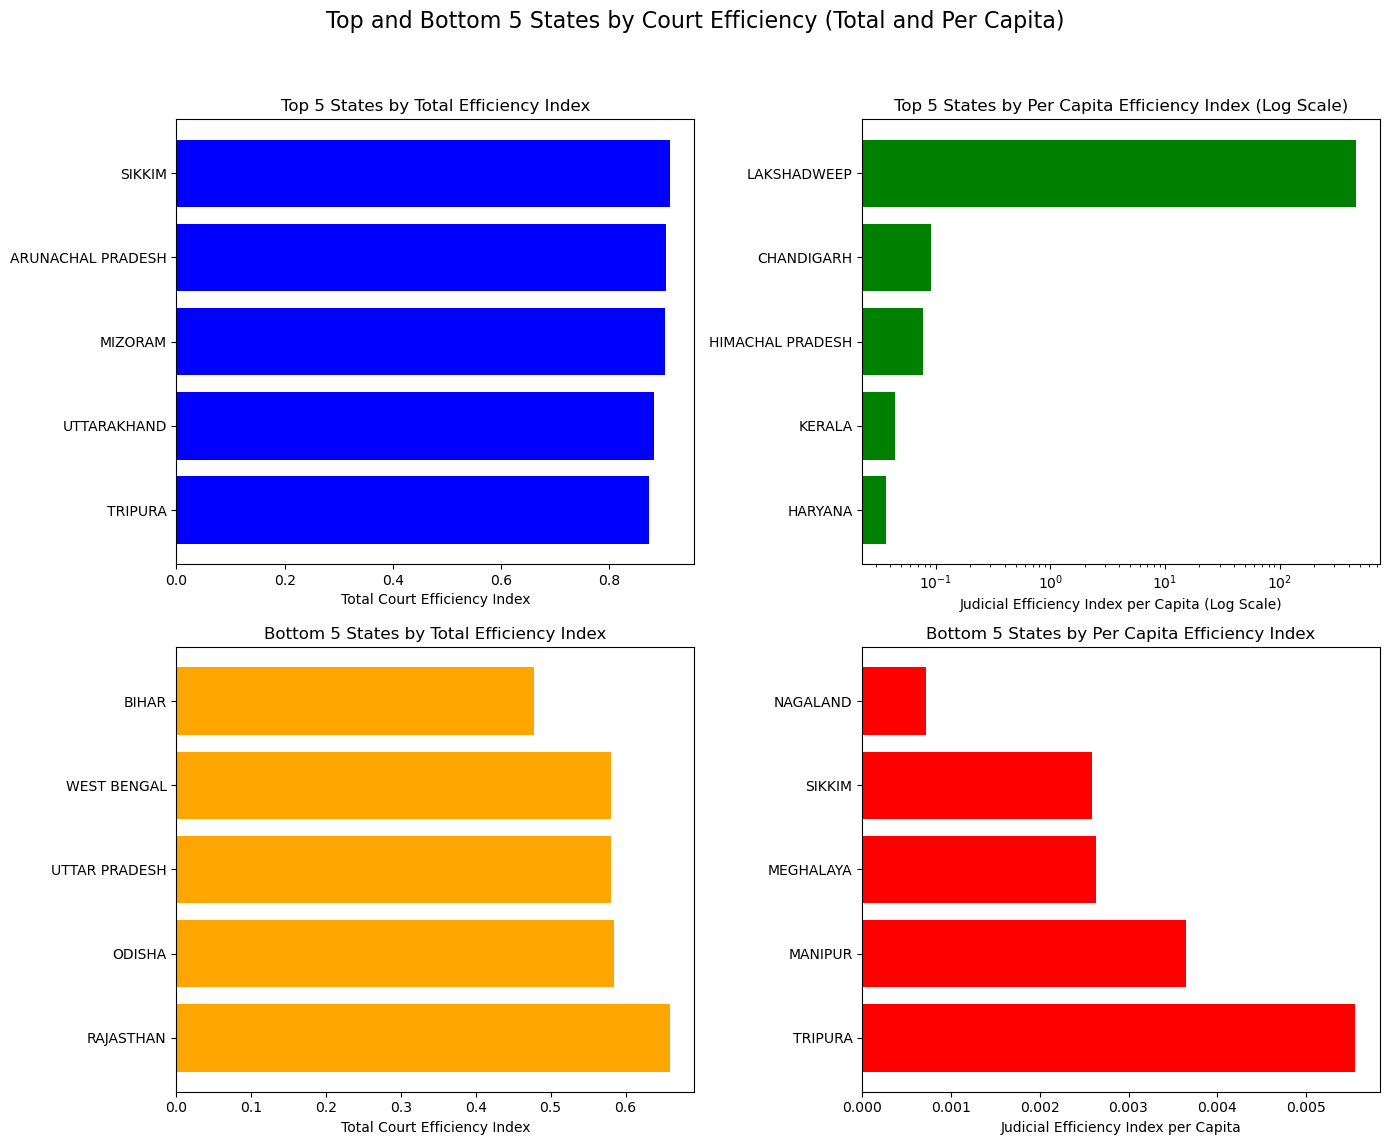

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data files
efficiency_index_df = pd.read_csv('Statewise_Judicial_Efficiency_Index_Per_Capita.csv')
total_cases_df = pd.read_csv('Statewise_Total_Cases_Court_Efficiency.csv')

# Find the top and bottom 5 states based on Total Court Efficiency Index and Per Capita Efficiency Index
# Sort by Total Court Efficiency Index for top and bottom 5
top_total_efficiency = efficiency_index_df.nlargest(5, 'Total_Court_Efficiency_Index')[['State_Name', 'Total_Court_Efficiency_Index']]
bottom_total_efficiency = efficiency_index_df.nsmallest(5, 'Total_Court_Efficiency_Index')[['State_Name', 'Total_Court_Efficiency_Index']]

# Sort by Judicial Efficiency Index per Capita for top and bottom 5
top_per_capita_efficiency = efficiency_index_df.nlargest(5, 'Judicial_Efficiency_Index_per_Capita')[['State_Name', 'Judicial_Efficiency_Index_per_Capita']]
bottom_per_capita_efficiency = efficiency_index_df.nsmallest(5, 'Judicial_Efficiency_Index_per_Capita')[['State_Name', 'Judicial_Efficiency_Index_per_Capita']]

# Plotting the top and bottom states side by side for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Top and Bottom 5 States by Court Efficiency (Total and Per Capita)', fontsize=16)

# Top 5 by Total Efficiency Index
axes[0, 0].barh(top_total_efficiency['State_Name'], top_total_efficiency['Total_Court_Efficiency_Index'], color="blue")
axes[0, 0].set_title('Top 5 States by Total Efficiency Index')
axes[0, 0].set_xlabel('Total Court Efficiency Index')
axes[0, 0].invert_yaxis()

# Bottom 5 by Total Efficiency Index
axes[1, 0].barh(bottom_total_efficiency['State_Name'], bottom_total_efficiency['Total_Court_Efficiency_Index'], color="orange")
axes[1, 0].set_title('Bottom 5 States by Total Efficiency Index')
axes[1, 0].set_xlabel('Total Court Efficiency Index')
axes[1, 0].invert_yaxis()

# Top 5 by Per Capita Efficiency Index with Log Scale for better visibility
axes[0, 1].barh(top_per_capita_efficiency['State_Name'], top_per_capita_efficiency['Judicial_Efficiency_Index_per_Capita'], color="green")
axes[0, 1].set_xscale('log')  # Apply logarithmic scale for better visibility
axes[0, 1].set_title('Top 5 States by Per Capita Efficiency Index (Log Scale)')
axes[0, 1].set_xlabel('Judicial Efficiency Index per Capita (Log Scale)')
axes[0, 1].invert_yaxis()

# Bottom 5 by Per Capita Efficiency Index
axes[1, 1].barh(bottom_per_capita_efficiency['State_Name'], bottom_per_capita_efficiency['Judicial_Efficiency_Index_per_Capita'], color="red")
axes[1, 1].set_title('Bottom 5 States by Per Capita Efficiency Index')
axes[1, 1].set_xlabel('Judicial Efficiency Index per Capita')
axes[1, 1].invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()


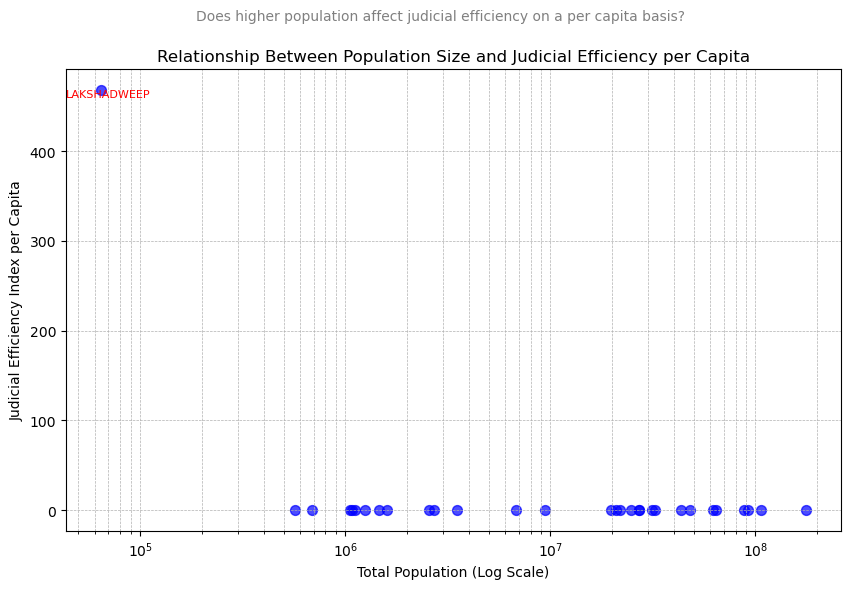

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting Population vs. Judicial Efficiency Index per Capita with Log Scale and Annotations
plt.figure(figsize=(10, 6))

# Scatter plot with a log scale for population to improve visibility
plt.scatter(efficiency_index_df['Total_Population'], efficiency_index_df['Judicial_Efficiency_Index_per_Capita'], 
            color="blue", alpha=0.7, s=50)

# Adding Logarithmic scale to x-axis for better distribution
plt.xscale('log')
plt.title('Relationship Between Population Size and Judicial Efficiency per Capita')
plt.suptitle('Does higher population affect judicial efficiency on a per capita basis?', fontsize=10, color='gray')
plt.xlabel('Total Population (Log Scale)')
plt.ylabel('Judicial Efficiency Index per Capita')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Annotate significant outliers if any
outliers = efficiency_index_df[efficiency_index_df['Judicial_Efficiency_Index_per_Capita'] > 100]
for _, row in outliers.iterrows():
    plt.annotate(row['State_Name'], (row['Total_Population'], row['Judicial_Efficiency_Index_per_Capita']),
                 textcoords="offset points", xytext=(5,-5), ha='center', fontsize=8, color='red')

# Display the plot
plt.show()


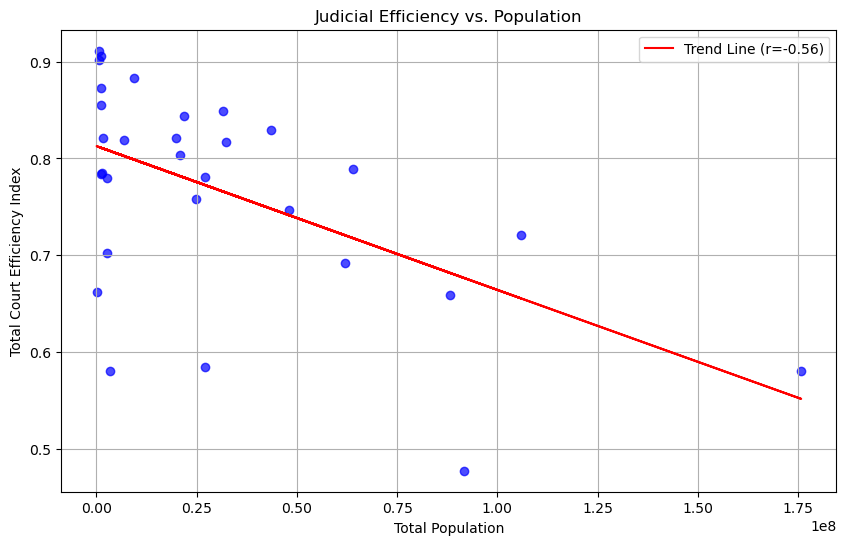

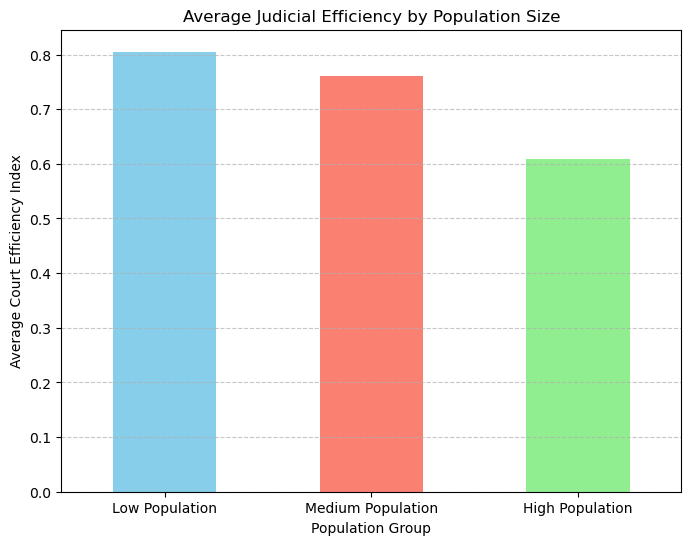

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Load data files
efficiency_index_df = pd.read_csv('Statewise_Judicial_Efficiency_Index_Per_Capita.csv')

# Scatter Plot with Trend Line for Population vs. Total Efficiency Index
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(efficiency_index_df['Total_Population'], efficiency_index_df['Total_Court_Efficiency_Index'], color="blue", alpha=0.7)
plt.title('Judicial Efficiency vs. Population')
plt.xlabel('Total Population')
plt.ylabel('Total Court Efficiency Index')
plt.grid(True)

# Trend Line (Linear Regression)
slope, intercept, r_value, p_value, std_err = linregress(efficiency_index_df['Total_Population'], efficiency_index_df['Total_Court_Efficiency_Index'])
plt.plot(efficiency_index_df['Total_Population'], intercept + slope * efficiency_index_df['Total_Population'], color='red', label=f'Trend Line (r={r_value:.2f})')
plt.legend()

# Show Scatter Plot with Trend Line
plt.show()

# Group States into Population Bins and Compare Efficiency
# Defining population bins (low, medium, high population)
bins = [0, 25000000, 75000000, 200000000]  # Example bins
labels = ['Low Population', 'Medium Population', 'High Population']
efficiency_index_df['Population_Bin'] = pd.cut(efficiency_index_df['Total_Population'], bins=bins, labels=labels)

# Calculate mean efficiency index for each population bin with observed=True to avoid warnings
population_bin_means = efficiency_index_df.groupby('Population_Bin', observed=True)['Total_Court_Efficiency_Index'].mean()

# Plotting the average efficiency by population bin
plt.figure(figsize=(8, 6))
population_bin_means.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Average Judicial Efficiency by Population Size')
plt.xlabel('Population Group')
plt.ylabel('Average Court Efficiency Index')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Show Population Bins Bar Chart
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Load the dataset
efficiency_index_df = pd.read_csv('Statewise_Judicial_Efficiency_Index_Per_Capita.csv')

# Identify the top and bottom 5 states based on both Total Court Efficiency Index and Judicial Efficiency Index per Capita
# Get top and bottom states based on Total Court Efficiency Index
top_total_efficiency = set(efficiency_index_df.nlargest(5, 'Total_Court_Efficiency_Index')['State_Name'])
bottom_total_efficiency = set(efficiency_index_df.nsmallest(5, 'Total_Court_Efficiency_Index')['State_Name'])

# Get top and bottom states based on Judicial Efficiency Index per Capita
top_per_capita_efficiency = set(efficiency_index_df.nlargest(5, 'Judicial_Efficiency_Index_per_Capita')['State_Name'])
bottom_per_capita_efficiency = set(efficiency_index_df.nsmallest(5, 'Judicial_Efficiency_Index_per_Capita')['State_Name'])

# Plotting
plt.figure(figsize=(14, 10))

# Top performing states Venn diagram with explanation
plt.subplot(2, 1, 1)
venn2([top_total_efficiency, top_per_capita_efficiency], ('Top Total Efficiency', 'Top Per Capita Efficiency'))
plt.title("Top 5 States in Both Metrics")

# Adding a detailed explanation for the top performing Venn diagram
top_explanation = """
This diagram compares the top 5 states by two metrics:
1. **Top Total Efficiency**: States with high overall court efficiency, regardless of population.
2. **Top Per Capita Efficiency**: States with high efficiency adjusted per individual resident.

Observation: No overlap between the two groups. This means states with the best court systems overall don't necessarily have the best access or efficiency for each individual.
"""
plt.figtext(0.1, 0.35, top_explanation, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='lightgrey', alpha=0.5, boxstyle="round,pad=0.5"))

# Bottom performing states Venn diagram with explanation
plt.subplot(2, 1, 2)
venn2([bottom_total_efficiency, bottom_per_capita_efficiency], ('Bottom Total Efficiency', 'Bottom Per Capita Efficiency'))
plt.title("Bottom 5 States in Both Metrics")

# Adding a detailed explanation for the bottom performing Venn diagram
bottom_explanation = """
This diagram compares the bottom 5 states by two metrics:
1. **Bottom Total Efficiency**: States with low overall court efficiency, regardless of population.
2. **Bottom Per Capita Efficiency**: States with low efficiency when adjusted per individual resident.

Observation: No overlap between the two groups. This suggests that states with generally inefficient courts aren't necessarily the least efficient when adjusted for individual access.
"""
plt.figtext(0.1, 0.05, bottom_explanation, wrap=True, horizontalalignment='left', fontsize=10, bbox=dict(facecolor='lightgrey', alpha=0.5, boxstyle="round,pad=0.5"))

plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Added padding to fit title and explanation boxes
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
efficiency_index_df = pd.read_csv('Statewise_Judicial_Efficiency_Index_Per_Capita.csv')

# Get top 5 states by Total Court Efficiency Index
top_efficiency_states = efficiency_index_df.nlargest(5, 'Total_Court_Efficiency_Index')
bottom_efficiency_states = efficiency_index_df.nsmallest(5, 'Total_Court_Efficiency_Index')

# Calculate average cases per capita for top and bottom states
avg_cases_per_capita_top = top_efficiency_states['Cases_per_Capita'].mean()
avg_cases_per_capita_bottom = bottom_efficiency_states['Cases_per_Capita'].mean()

# Define categories and values for the bar chart
categories = ['Top Efficiency States', 'Bottom Efficiency States']
average_cases_per_capita = [avg_cases_per_capita_top, avg_cases_per_capita_bottom]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(categories, average_cases_per_capita, color=['blue', 'orange'])
plt.ylabel('Average Cases per Capita')
plt.title('Average Cases per Capita: Top vs. Bottom Efficiency States')

# Add descriptions to make it accessible for layman understanding
description_text = """
This chart compares the average number of court cases per person (cases per capita) between the top and bottom efficiency states:

1. **Top Efficiency States (Blue)**: These states have the highest judicial efficiency. On average, each person has fewer court cases, meaning there is a lighter workload for the court system in these states.
2. **Bottom Efficiency States (Orange)**: These states have the lowest judicial efficiency. They have more court cases per person, indicating that the courts handle a heavier workload.

**Insight**: States with higher efficiency manage fewer cases per person, suggesting that a lighter workload might contribute to better court performance.
"""

# Positioning the description below the chart
plt.figtext(0.1, -0.15, description_text, wrap=True, horizontalalignment='left', fontsize=10, 
            bbox=dict(facecolor='lightgrey', alpha=0.5, boxstyle="round,pad=0.5"))

plt.tight_layout(rect=[0, 0.3, 1, 0.95])
plt.show()
